# NHANES I dataset from shap

In [83]:
%load_ext autoreload
%autoreload 2

In [84]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', 80)

import shap

from stratx.partdep import *
from impimp import *
from support import *

def fix_missing_num(df, colname):
    df[colname+'_na'] = pd.isnull(df[colname]).astype(int)
    df[colname].fillna(df[colname].median(), inplace=True)

In [85]:
X,y = shap.datasets.nhanesi()
X = X.drop('Unnamed: 0', axis=1)
X['Race'] = X['Race'].astype(int)
X['Sex'] = X['Sex'].astype(int)
n = X.shape[0]
X.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1,128.0,386.0,49.7,8.1,20.354684,58.0


In [86]:
shap_paper_features = ['Age', 'Sex', 'Poverty index', 'Systolic BP', 'Serum Cholesterol',
                       'Pulse pressure', 'BMI', 'White blood cells',
                       'Sedimentation rate', 'TS', 'Serum Magnesium', 
                       'Serum Protein', 'Serum Iron',
                       'Red blood cells', 'Race']

In [87]:
X = X[shap_paper_features].copy()

In [88]:
for feature in ['Sedimentation rate', 'Systolic BP', 'White blood cells', 'Pulse pressure']:
    fix_missing_num(X, feature)

In [89]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1)
rf.fit(X,y)
rf.oob_score_

0.3259717799664694

In [90]:
# From https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(rf.predict(X), y)

0.8154938814640218

In [91]:
%time shap_values = shap.TreeExplainer(rf).shap_values(X[:200])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 1min 27s, sys: 325 ms, total: 1min 27s
Wall time: 1min 27s


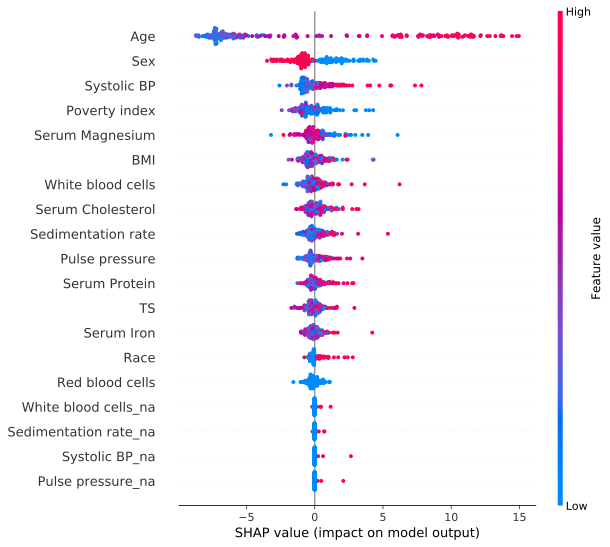

CPU times: user 1 s, sys: 11.8 ms, total: 1.01 s
Wall time: 1.01 s


In [92]:
%time shap.summary_plot(shap_values, X[:200])

In [93]:
shap_I = shap_importances(rf, X, n_shap=100, normalize=True)

SHAP time for 100 records using RandomForestRegressor = 7.7s


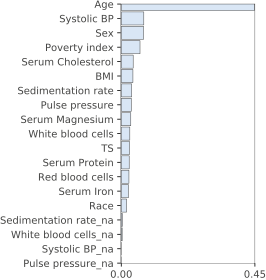

In [94]:
plot_importances(shap_I)

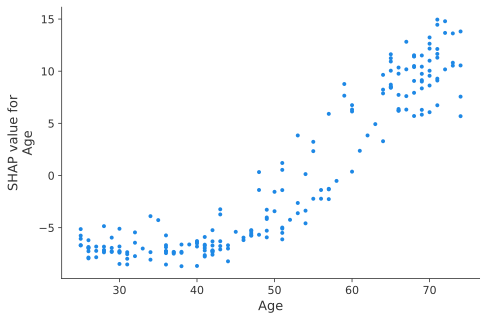

In [95]:
shap.dependence_plot("Age", shap_values, X[:200], interaction_index=None)

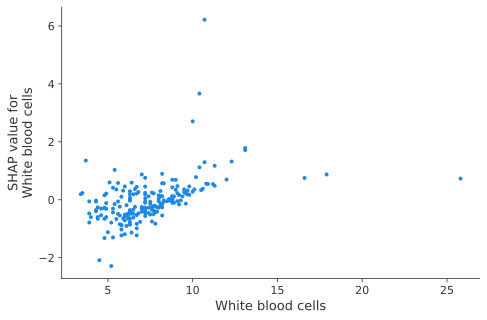

In [96]:
shap.dependence_plot("White blood cells", shap_values, X[:200], interaction_index=None)

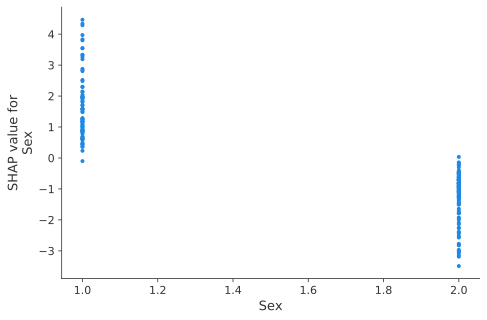

In [97]:
shap.dependence_plot("Sex", shap_values, X[:200], interaction_index=None)

In [98]:
I = impact_importances(X, pd.Series(y), min_samples_leaf=10,
                            catcolnames={'Sex','Race'},
                            min_slopes_per_x=int(n*0.03))

Impact importance time 9s


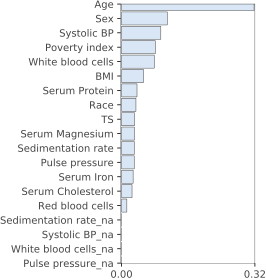

In [99]:
plot_importances(I)

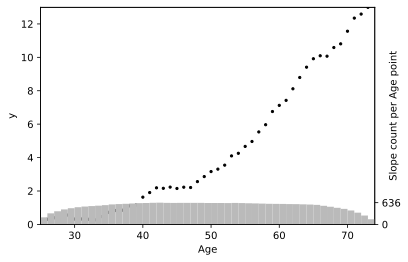

In [100]:
plot_stratpd(X, pd.Series(y), 'Age', 'y',
             show_slope_counts=True,
             min_slopes_per_x=5,
             min_samples_leaf=10,
             show_slope_lines=False)
plt.show()

29.796


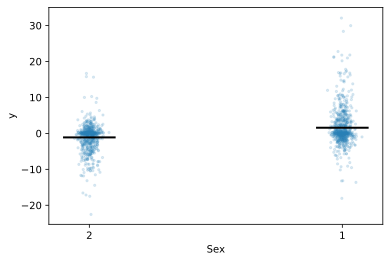

In [101]:
print(n*0.003)
plot_catstratpd(X, pd.Series(y), 'Sex', 'y',
             min_samples_leaf=10,
             min_y_shifted_to_zero=False)
plt.show()